In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using Bump10MSun
using Distributions
using HDF5
using LaTeXStrings
using Printf
using MCMCChains
using MCMCChainsStorage
using StatsBase
using StatsPlots
using Trapz

Here we are fitting 
$$
\frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} m_2 \mathrm{d} V \mathrm{d} t} = \frac{R}{m_1 m_2} g\left( q \right) f\left( m_1 \right) f\left( m_2 \right)
$$
where the "common" mass function
$$
f\left( m \right) = \begin{cases}
\left( \frac{m}{m_b} \right)^{\alpha_1} & m < m_b \\
\left( \frac{m}{m_b} \right)^{\alpha_2} & m \geq m_b 
\end{cases}
$$
and the "pairing" function is a Gaussian in mass ratio, given by 
$$
g\left( q \right) = \exp\left( - \frac{\left( q - \mu_q \right)^2}{2 \sigma_q^2} + \frac{\left( 1 - \mu_q \right)^2}{2 \sigma_q^2}\right)
$$
for 
$$
3 \, M_\odot < m_2 < m_1 < 20 \, M_\odot.
$$
(Note: the definition above implies that $R$ is the volumetric merger rate per log mass squared at $m_1 = m_2 = m_b$.)

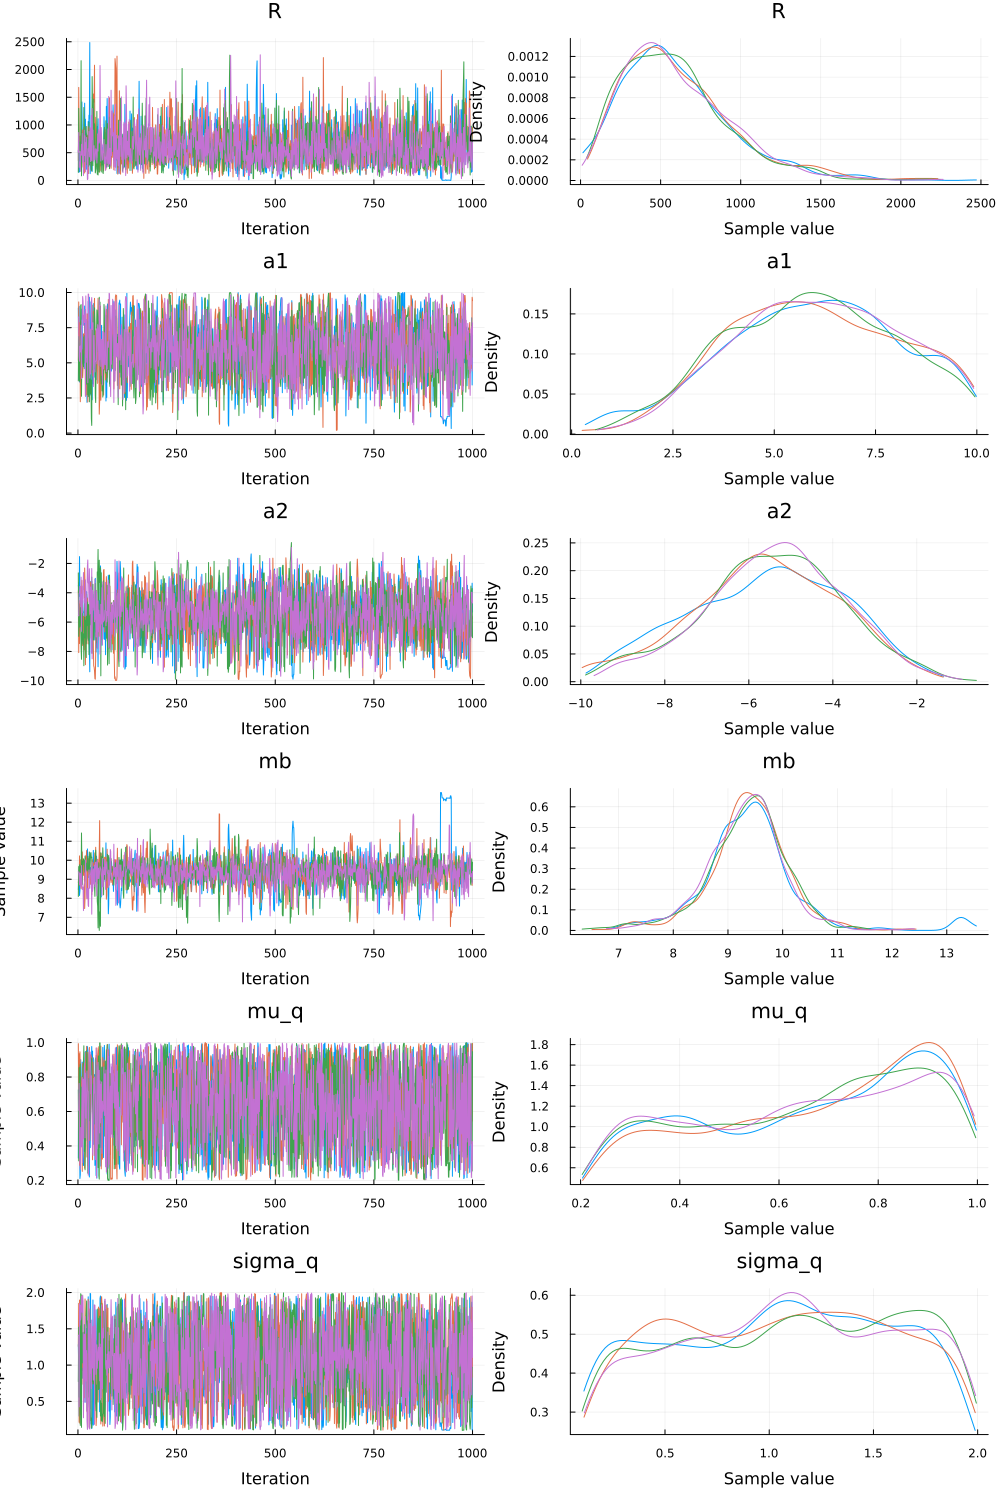

In [3]:
trace = h5open(joinpath(@__DIR__, "..", "chains", "chains.h5"), "r") do f
    read(f, Chains)
end
var_names = [:a1, :a2, :mb, :mu_q, :sigma_q, :R]
plot(trace[var_names])

In [22]:
dNdm1dm2 = map(trace[:a1], trace[:a2], trace[:mb], trace[:mu_q], trace[:sigma_q], trace[:R]) do a1, a2, mb, mu_q, sigma_q, R
    ldN = make_log_dN(a1, a2, mb, mu_q, sigma_q)
    (m1, m2) -> R*exp(ldN(m1,m2))
end
dNdm1 = map(trace[:a1], trace[:a2], trace[:mb], trace[:mu_q], trace[:sigma_q], trace[:R]) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdm1(a1, a2, mb, mu_q, sigma_q)
    m1 -> R*dN(m1)
end
dNdm2 = map(trace[:a1], trace[:a2], trace[:mb], trace[:mu_q], trace[:sigma_q], trace[:R]) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdm2(a1, a2, mb, mu_q, sigma_q)
    m2 -> R*dN(m2)
end
dNdq = map(trace[:a1], trace[:a2], trace[:mb], trace[:mu_q], trace[:sigma_q], trace[:R]) do a1, a2, mb, mu_q, sigma_q, R
    dN = make_dNdq(a1, a2, mb, mu_q, sigma_q)
    q -> R*dN(q)
end
dNdm_pl = map(trace[:a1], trace[:a2], trace[:mb], trace[:R]) do a1, a2, mb, R
    dN = make_dNdm(a1, a2, mb)
    m -> sqrt(R)*dN(m)
end
pprob = map(trace[:mu_q], trace[:sigma_q]) do mu_q, sigma_q
    pf = make_pairing_prob(mu_q, sigma_q)
    q -> pf(q)
end;

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106


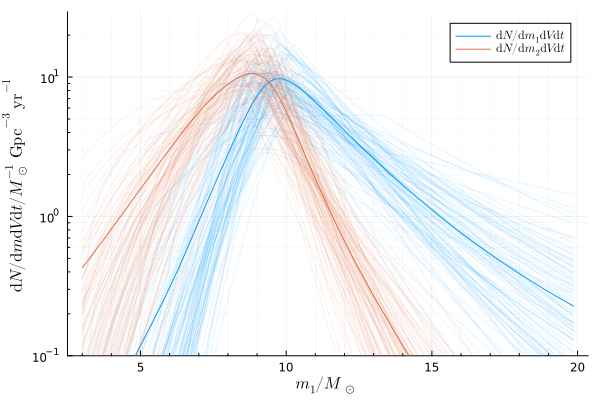

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [5]:
ms = exp.(log(mlow):0.01:log(mhigh))
dN1_mean = zeros(length(ms))
dN2_mean = zeros(length(ms))

p = plot()

for dN in dNdm1
    dN1_mean = dN1_mean .+ dN.(ms)
end
dN1_mean = dN1_mean ./ length(dNdm1)
p = plot!(ms, dN1_mean, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_1\mathrm{d}V\mathrm{d}t", minorgrid=true)
for _ in 1:100
    p = plot!(ms, sample(dNdm1).(ms), color=1, alpha=0.1, label=nothing)
end

for dN in dNdm2
    dN2_mean = dN2_mean .+ dN.(ms)
end
dN2_mean = dN2_mean ./ length(dNdm1)
p = plot!(ms, dN2_mean, color=2, yscale=:log10, ylims=(0.1, Inf), xlabel=L"m_1 / M_\odot", ylabel=L"\mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / M_\odot^{-1}\, \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", label=L"\mathrm{d}N/\mathrm{d}m_2 \mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, sample(dNdm2).(ms), color=2, alpha=0.1, label=nothing)
end

p

Let's look at $\mathrm{d} N/\mathrm{d} q$:

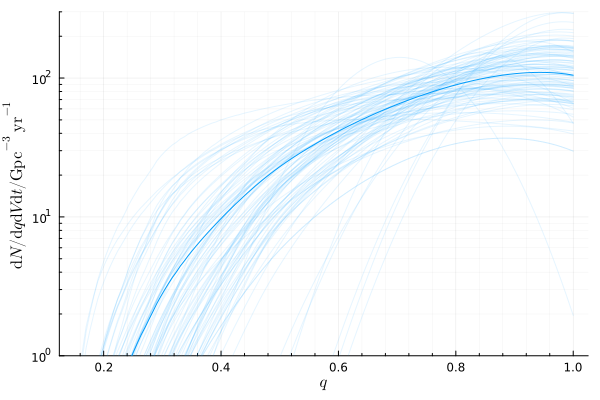

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/wfarr/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [6]:
qs = collect(range(mlow/mhigh, stop=1, length=128))
dNdq_mean = zeros(length(qs))

for dN in dNdq
    dNdq_mean .= dNdq_mean .+ dN.(qs)
end
dNdq_mean .= dNdq_mean ./ length(dNdq)
p = plot(qs, dNdq_mean, color=1, yscale=:log10, ylims=(1e0, 3e2), legend=nothing, minorgrid=true, xlabel=L"q", ylabel=L"\mathrm{d}N/\mathrm{d}q\mathrm{d}V\mathrm{d}t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}")

for _ in 1:100
    p = plot!(qs, sample(dNdq).(qs), color=1, alpha=0.1)
end

p

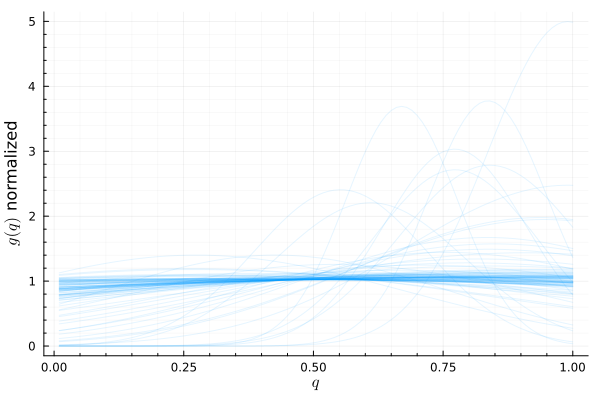

In [43]:
pp = plot(xlabel=L"q", ylabel=L"$g(q)$ normalized", legend=nothing, minorgrid=true)
for _ in 1:100
    p = sample(pprob)
    pb = p.(qs)
    pb /= trapz(qs, pb)
    pp = plot!(qs, pb, color=1, alpha=0.1, label=nothing)
end
pp

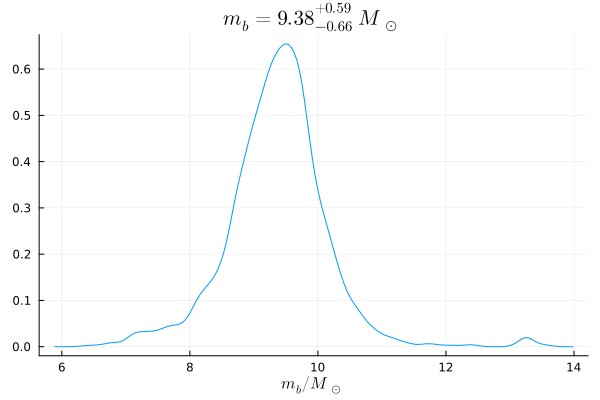

In [44]:
x = vec(trace[:mb])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

@df trace density(:mb, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_b = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

In [31]:
function m1pct(ms, f)
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 1 method)

In [46]:
m1pct_m1 = map(dNdm1) do dN
    m1pct(ms, dN)
end
m1pct_m2 = map(dNdm2) do dN
    m1pct(ms, dN)
end
m1pct_pl = map(dNdm_pl) do dN
    m1pct(ms, dN)
end;

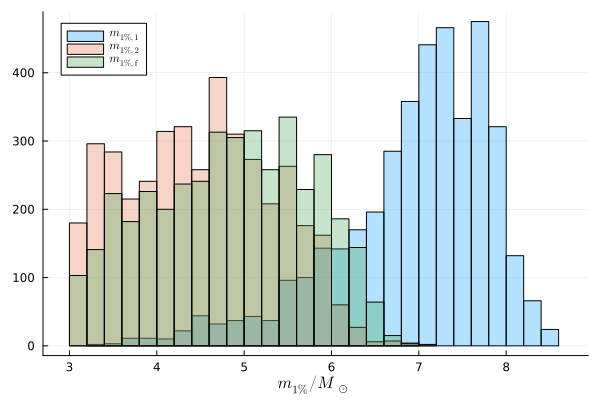

In [53]:
histogram(vec(m1pct_m1), label=L"m_{1\%,1}", xlabel=L"m_{1\%} / M_\odot", fillalpha=0.3)
histogram!(vec(m1pct_m2), label=L"m_{1\%,2}", fillalpha=0.3)
histogram!(vec(m1pct_pl), label=L"m_{1\%,\mathrm{f}}", fillalpha=0.3)